In [1]:
from typing import TYPE_CHECKING

import numpy as np
import numpy.typing as npt
import torch
from pyquaternion import Quaternion

In [14]:
from xml.dom import minidom
import json

doc = minidom.parse('Frame 3.svg')
path_strings = [
    path.getAttribute('d') for path in doc.getElementsByTagName('path')
]
# print(path_strings)

paths = []

for s in path_strings:
    assert s[0] == 'M', s
    # s = s[1:]
    i = 1
    points = []
    point = 'M'
    while True:
        if i >= len(s) or 'A' <= s[i] <= 'Z':
            # process point
            identifier = point[0]
            point = point[1:]
            if identifier == 'Z':
                points.append(points[0])
                break
            assert any(c in '0123456789. -' for c in point), point
            if identifier in 'ML':
                points.append([float(p) for p in point.split(' ')])
            elif identifier == 'V':
                assert ' ' not in point, point
                points.append([points[-1][0], float(point)])
                pass
            elif identifier == 'H':
                assert ' ' not in point, point
                points.append([float(point), points[-1][1]])
                pass
            else:
                raise Exception('Unknown identifier: ' + identifier)
            # print(points[-1])
            point = ''
        else:
            assert s[i] in '0123456789. -', s
        if i >= len(s):
            break
        point += s[i]
        i += 1
    paths.append(points)
    
doc.unlink()

intersection = paths[0]
intersection_segment = paths[1]
paths = paths[2:]
assert len(paths) == 16
lanes = paths[:8]
lane_segment = paths[8:]

DIRECTIONS = ['south', 'east', 'north', 'west']
OUTINS = ['out', 'in']
ids = []
for d in DIRECTIONS:
    for oi in OUTINS:
        ids.append(d + '-' + oi)

polygons = []
intersections = []
segments = []

intersections = [{'id': 'intersection_inter', 'road': 'intersection'}]
segments.append({
    'start': 'POINT ()',
    'end': 'POINT ()',
    'heading': 0,
    'polygonId': 'intersection',
})

In [54]:
CAMERA_INTRINSIC = np.array([
    [1272,    0, 960],
    [   0, 1272, 540],
    [   0,    0,   1]
])

CAMERA_TRANSLATION = np.array([0, 0, 5])

CAMERA_ROTATION = Quaternion((0.430, -0.561, 0.561, -0.430))

In [55]:
def run(data):
    with torch.no_grad():
        [[fx, s, x0], [_, fy, y0], [_, _, _]] = CAMERA_INTRINSIC
        rotation = CAMERA_ROTATION
        translation = CAMERA_TRANSLATION

        # TODO: should it be a 2D bbox in 3D?
        bottoms = data
        N = bottoms.shape[1] // 2
        assert (2, N * 2) == bottoms.shape, ((2, N * 2), bottoms.shape)

        # TODO: use matrix multiplication with K^-1
        directions = np.stack(
            (
                (bottoms[0] / fx)
                - (s * bottoms[1] / (fx * fy))
                + ((s * y0) / (fx * fy))
                - (x0 / fx),
                (bottoms[1] - y0) / fy,
                np.ones(N * 2),
            )
        )
        assert (3, N * 2) == directions.shape, ((3, N * 2), directions.shape)

        rotated_directions = rotate(directions, rotation)

        # find t that z=0
        ts = -translation[2] / rotated_directions[2, :]

        points = rotated_directions * ts + translation[:, np.newaxis]
        points_from_camera = rotate(points - translation[:, np.newaxis], rotation.inverse)

        bbox3d = np.concatenate(
            (
                points[:, :N],
                points[:, N:],
            ),
            axis=0,
        ).T
        assert (N, 6) == bbox3d.shape, bbox3d.shape

        bbox3d_from_camera = np.concatenate(
            (
                points_from_camera[:, :N],
                points_from_camera[:, N:],
            ),
            axis=0,
        ).T
        assert (N, 6) == bbox3d_from_camera.shape, bbox3d_from_camera.shape

        # d3d = torch.concatenate(
        #     (
        #         torch.tensor(bbox3d),
        #         torch.tensor(bbox3d_from_camera),
        #     ),
        #     dim=1,
        # )
        # # assert (N, (d + 12)) == d3d.shape, d3d.shape

        return bbox3d


def rotate(vectors: "npt.NDArray", rotation: "Quaternion") -> "npt.NDArray":
    """Rotate 3D Vector by rotation quaternion.
    Params:
        vectors: (3 x N) 3-vectors each specified as any ordered
            sequence of 3 real numbers corresponding to x, y, and z values.
        rotation: A rotation quaternion.

    Returns:
        The rotated vectors (3 x N).
    """
    return rotation.unit.rotation_matrix @ vectors


def conj(q: "npt.NDArray") -> "npt.NDArray":
    return np.concatenate([q[0:1, :], -q[1:, :]])


In [56]:
np.array(lanes[0]).T


array([[ -95. ,  469. , 1011. ,  123.5,  -95. ,  -95. ],
       [ 947. ,  812. ,  907. , 1293. ,  947. ,  947. ]])

In [57]:
# data = [
#     [x0, x1, x2, ...],
#     [y0, y1, y2, ...]
# ]
result = run(data=np.array(intersection).T)

In [58]:
x = []
y = []
for path in [intersection] + lanes:
    result = run(data=np.array(path).T)
    for point in result:
        x.append(point[0])
        y.append(point[1])
        x.append(point[3])
        y.append(point[4])

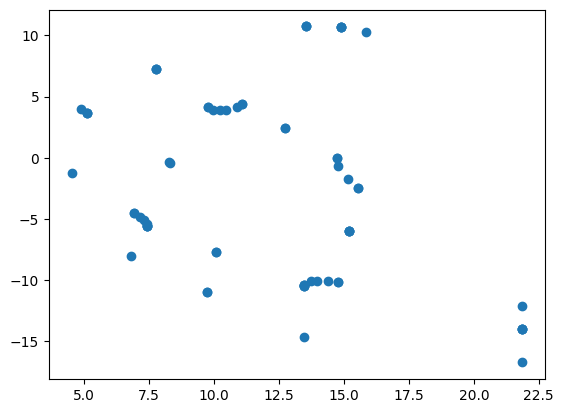

: 

In [59]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(x, y)
plt.show()